In [182]:
import maze_library
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import random

In [183]:
def map_int_to_direction(input):
    if input == 0:
        return maze_library.Direction.North
    if input == 1:
        return maze_library.Direction.East
    if input == 2:
        return maze_library.Direction.South
    else:
        return maze_library.Direction.West

In [184]:
env = maze_library.init_environment_python(10,10,5)
maze_library.create_kruzkals_maze(env)
maze_library.make_maze_imperfect(env)

In [185]:
def action_result_to_tuple(action_result):
    """
    Converts an ActionResult object into a tuple.

    Args:
        action_result (ActionResult): The result of an action in the environment.

    Returns:
        tuple: (observation, reward, done, truncated, info)
    """
    observation = action_result.observation  # The new observation after taking action
    reward = action_result.reward  # Reward received
    done = action_result.is_done  # Whether the episode is finished
    truncated = action_result.is_truncated  # Whether the episode was truncated
    info = action_result.info # Additional info

    return observation, reward, done, truncated, info


In [186]:
def action_result_to_input_vector(state, info):
    available_paths = state.available_paths
    visited_paths = state.visited_paths
    return np.array([
        available_paths.get(maze_library.Direction.North, 0),
        visited_paths.get(maze_library.Direction.North, False),
        available_paths.get(maze_library.Direction.East, 0),
        visited_paths.get(maze_library.Direction.East, False),
        available_paths.get(maze_library.Direction.South, 0),
        visited_paths.get(maze_library.Direction.South, False),
        available_paths.get(maze_library.Direction.West, 0),
        visited_paths.get(maze_library.Direction.West, False),
        info.previous_direction,
        state.current_location[0]/10 ,
        state.current_location[1]/10 ,
        state.end_node[0]/10 ,
        state.end_node[1]/10 ,
        info.previous_node[0]/10 ,
        info.previous_node[1]/10 ,
        info.manhattan_distance /10,
        info.goal_dx,
        info.goal_dy,
        info.visited_amount 

    ])

In [187]:


class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.out = nn.Linear(64, output_size)

    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        return self.out(x)
    
    
input_size = 19
output_size = 4
model = DQN(input_size, output_size)
optimizer = torch.optim.NAdam(model.parameters(), lr=5e-5)
loss_fn = nn.HuberLoss()
replay_buffer = deque(maxlen=8000)


In [188]:
def epsilon_greedy_policy(state, epsilon):
    if random.random() < epsilon:
        return random.randint(0, output_size - 1)
    with torch.no_grad():
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        q_values = model(state_tensor)
        return int(torch.argmax(q_values).item())


In [189]:
from collections import deque

replay_buffer = deque(maxlen=8000)

In [190]:
# def sample_experiences(batch_size):
#     sorted_experiences = sorted(replay_buffer, key=lambda exp: abs(exp[2]), reverse=True)
#     half_batch = batch_size // 2

#     # Ensure there are enough samples to choose from
#     num_experiences = len(sorted_experiences)
#     if num_experiences < batch_size:
#         batch = sorted_experiences
#     else:
#         high_priority_samples = sorted_experiences[:half_batch]
#         random_samples = [sorted_experiences[i] for i in np.random.choice(num_experiences, half_batch, replace=False)]
#         batch = high_priority_samples + random_samples
    
#     return [
#         np.array([experience[field_index] for experience in batch], dtype=np.float32)
#         for field_index in range(6)
#     ]

def sample_experiences(batch_size):
    indices = np.random.choice(len(replay_buffer), min(batch_size, len(replay_buffer)), replace=False)
    batch = [replay_buffer[i] for i in indices]
    return zip(*batch)



In [191]:
reward_log = []
def play_one_step(env, state, info, epsilon):
    flat_state = action_result_to_input_vector(state, info)
    action = epsilon_greedy_policy(flat_state, epsilon)
    action_obj = maze_library.create_action(map_int_to_direction(action), 0)
    next_state, reward, done, truncated, new_info = action_result_to_tuple(env.take_action(action_obj))
    flat_next_state = action_result_to_input_vector(next_state, new_info)
    replay_buffer.append((flat_state, action, reward, flat_next_state, done, truncated))
    reward_log.append(reward)
    return next_state, reward, done, truncated, new_info

In [192]:
np.random.seed(42)
rewards = [] 
highest_reward = -1000000

In [193]:
discount_factor = 0.96
q_value_log = []


def training_step(batch_size, discount_factor=0.94):
    states, actions, rewards, next_states, dones, _ = sample_experiences(batch_size)

    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int64)
    rewards = torch.tensor(rewards, dtype=torch.float32)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32)

    with torch.no_grad():
        next_q = model(next_states)
        max_next_q = next_q.max(dim=1)[0]
        target_q = rewards + (1 - dones) * discount_factor * max_next_q

    q_values = model(states)
    selected_q = q_values.gather(1, actions.unsqueeze(1)).squeeze()
    loss = loss_fn(selected_q, target_q)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    q_value_log.extend(selected_q.detach().numpy())

In [194]:
# Visualization function
def plot_q_values():
    plt.figure(figsize=(10, 5))
    plt.plot(q_value_log)
    plt.title("Q-Values Over Time")
    plt.xlabel("Training Steps")
    plt.ylabel("Q-Value")
    plt.grid(True)
    plt.show()


Episode: 0, Steps: 9, eps: 1.000, reward = -10.10000005364418
Episode: 100, Steps: 12, eps: 0.956, reward = -23.9000001847744
Episode: 120, Steps: 25, eps: 0.947, reward = 34.59999841451645
Episode: 200, Steps: 5, eps: 0.911, reward = -28.75
Episode: 300, Steps: 8, eps: 0.867, reward = -29.65000021457672
Episode: 400, Steps: 12, eps: 0.822, reward = -15.999999910593033


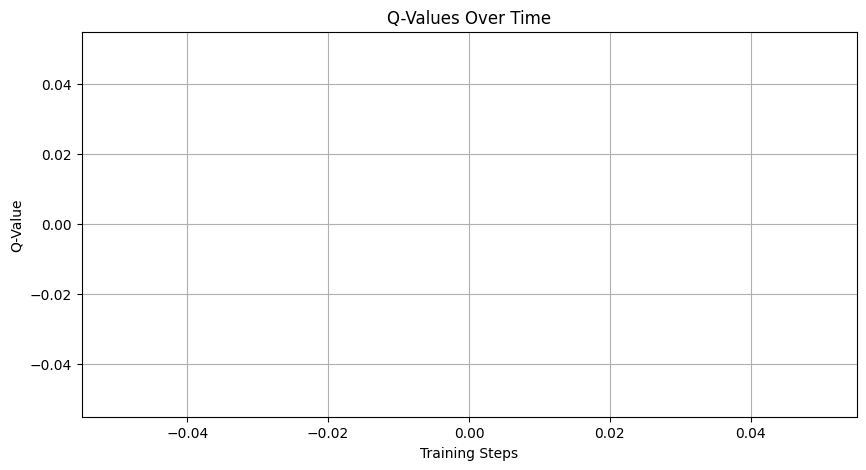

Episode: 500, Steps: 5, eps: 0.778, reward = -19.800000071525574
Episode: 600, Steps: 6, eps: 0.733, reward = -22.950000166893005
Episode: 700, Steps: 11, eps: 0.689, reward = -18.249999940395355
Episode: 800, Steps: 5, eps: 0.644, reward = -20.899999976158142
Episode: 900, Steps: 6, eps: 0.600, reward = -20.850000083446503


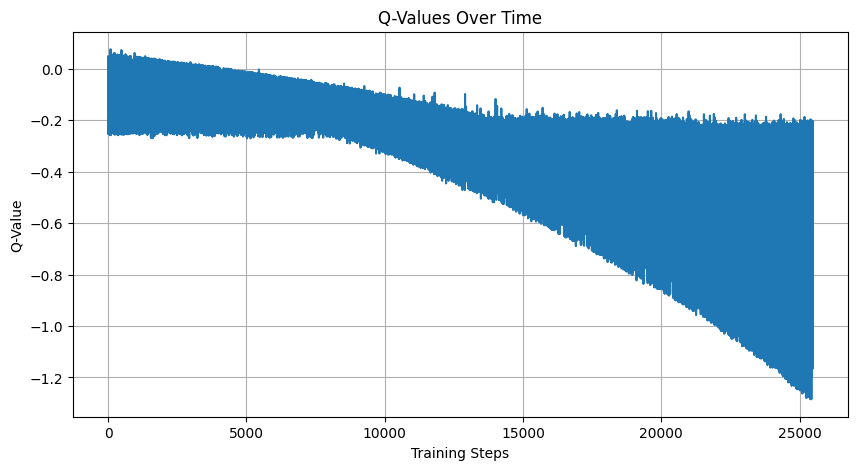

Episode: 1000, Steps: 6, eps: 0.556, reward = -21.149999797344208
Episode: 1100, Steps: 7, eps: 0.511, reward = -26.250000178813934
Episode: 1170, Steps: 14, eps: 0.480, reward = 49.649998754262924
Episode: 1200, Steps: 6, eps: 0.467, reward = -23.30000013113022
Episode: 1300, Steps: 5, eps: 0.422, reward = -18.79999989271164
Episode: 1371, Steps: 8, eps: 0.391, reward = 63.149998635053635
Episode: 1379, Steps: 19, eps: 0.387, reward = 47.349998474121094
Episode: 1391, Steps: 16, eps: 0.382, reward = 49.84999841451645
Episode: 1395, Steps: 12, eps: 0.380, reward = 54.79999849200249
Episode: 1400, Steps: 21, eps: 0.378, reward = 49.44999858736992
Episode: 1405, Steps: 11, eps: 0.376, reward = 60.799998730421066
Episode: 1410, Steps: 11, eps: 0.373, reward = 60.99999865889549
Episode: 1422, Steps: 15, eps: 0.368, reward = 54.149998515844345
Episode: 1436, Steps: 20, eps: 0.362, reward = 40.74999842047691


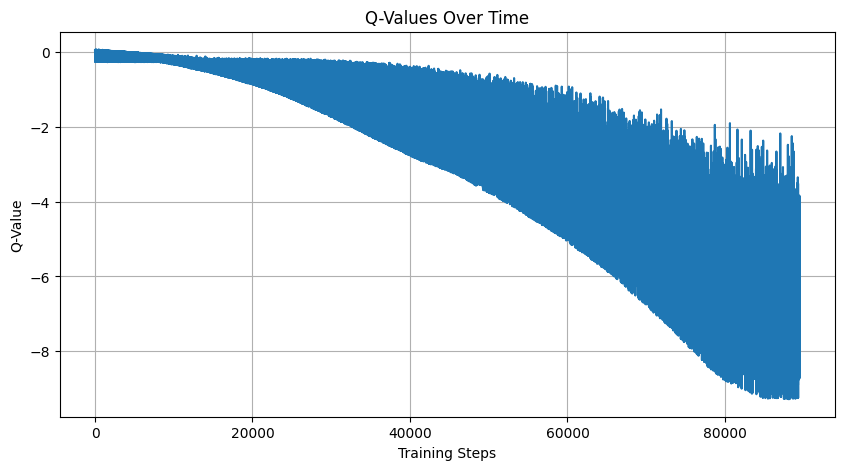

Episode: 1500, Steps: 5, eps: 0.333, reward = -26.5
Episode: 1512, Steps: 27, eps: 0.328, reward = 34.799998581409454
Episode: 1518, Steps: 20, eps: 0.325, reward = 42.899998515844345
Episode: 1538, Steps: 8, eps: 0.316, reward = 62.649998635053635
Episode: 1554, Steps: 16, eps: 0.309, reward = 45.59999853372574
Episode: 1555, Steps: 11, eps: 0.309, reward = 57.549998581409454
Episode: 1562, Steps: 17, eps: 0.306, reward = 41.549998730421066
Episode: 1569, Steps: 16, eps: 0.303, reward = 52.54999849200249
Episode: 1575, Steps: 19, eps: 0.300, reward = 44.399998515844345
Episode: 1586, Steps: 16, eps: 0.295, reward = 45.49999842047691
Episode: 1587, Steps: 20, eps: 0.295, reward = 41.64999833703041
Episode: 1590, Steps: 15, eps: 0.293, reward = 52.74999842047691
Episode: 1593, Steps: 16, eps: 0.292, reward = 44.7999983727932
Episode: 1595, Steps: 15, eps: 0.291, reward = 53.19999846816063
Episode: 1599, Steps: 13, eps: 0.289, reward = 52.44999858736992
Episode: 1600, Steps: 29, eps: 0.2

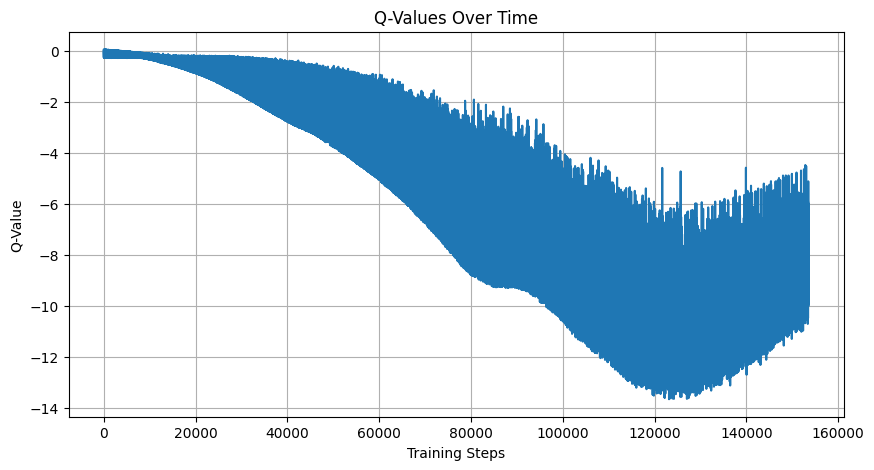

Episode: 2000, Steps: 8, eps: 0.111, reward = -13.899999856948853
Episode: 2029, Steps: 12, eps: 0.098, reward = 61.59999856352806
Episode: 2044, Steps: 13, eps: 0.092, reward = 58.29999861121178
Episode: 2067, Steps: 23, eps: 0.081, reward = 58.69999846816063
Episode: 2080, Steps: 8, eps: 0.076, reward = 63.149998635053635
Episode: 2100, Steps: 8, eps: 0.067, reward = -11.349999904632568
Episode: 2108, Steps: 9, eps: 0.063, reward = 60.4999985396862
Episode: 2141, Steps: 12, eps: 0.048, reward = 61.09999856352806
Episode: 2150, Steps: 11, eps: 0.044, reward = 62.89999860525131
Episode: 2158, Steps: 11, eps: 0.041, reward = 62.89999860525131
Episode: 2161, Steps: 12, eps: 0.040, reward = 61.09999856352806
Episode: 2162, Steps: 16, eps: 0.039, reward = 59.39999848604202
Episode: 2163, Steps: 12, eps: 0.039, reward = 61.59999856352806
Episode: 2164, Steps: 13, eps: 0.038, reward = 58.79999861121178
Episode: 2165, Steps: 12, eps: 0.038, reward = 61.59999856352806
Episode: 2166, Steps: 16,

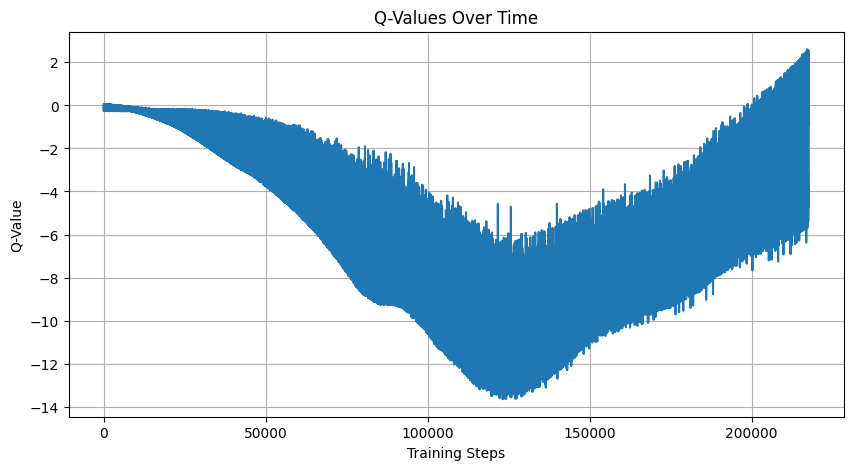

In [195]:
steps = 2500
batch_size = 128

# In the plotting function:
for episode in range(steps):
    result = env.reset()   
    obs, reward, done, truncated, info = action_result_to_tuple(result)
    cumilative_reward = 0
    for step in range(steps):
        epsilon = max(1 - episode / (steps * 0.9), 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, info, epsilon)
        cumilative_reward += reward
        if done or truncated:
            break

    # Extra debug information
    if episode% 100 == 0 or cumilative_reward > 0:
        print(f"\rEpisode: {episode}, Steps: {step}, eps: {epsilon:.3f}, reward = {cumilative_reward}")
    rewards.append(cumilative_reward)
    
    if cumilative_reward > highest_reward:
        best_weights = model.state_dict()
        highest_reward = cumilative_reward

    if episode > 800:
        training_step(batch_size)
    if episode % 500 == 499:
        plot_q_values()
        
    with open(f'../mazeLogs/solve{episode}.json', 'w') as file:
        file.write(env.to_json_python())

    


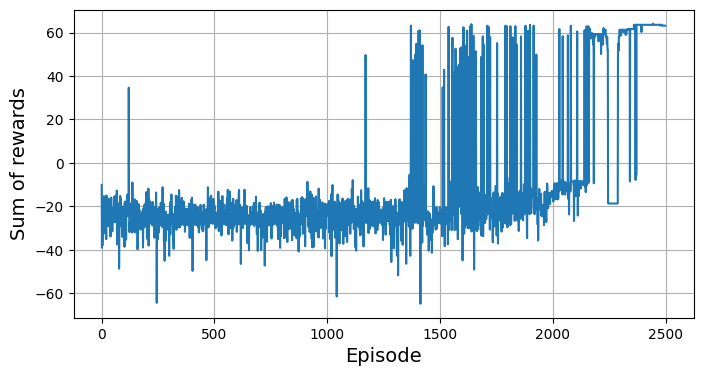

In [196]:
# extra code – this cell generates and saves Figure 18–10
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

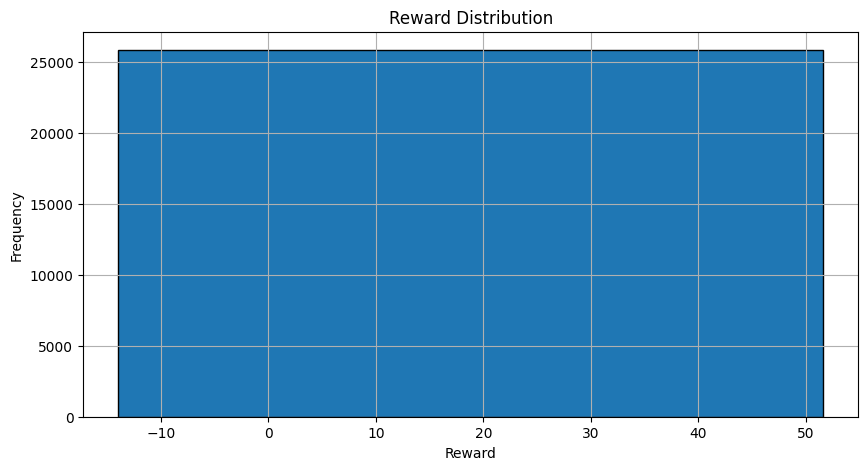

In [197]:
plt.figure(figsize=(10, 5))
plt.hist(reward_log, bins=1, edgecolor='black')
plt.title("Reward Distribution")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()